In [ ]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas as pd
import os
import ast
import numpy as np
import torch
import torchvision.transforms as tt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [3]:
od.download('https://www.kaggle.com/competitions/global-wheat-detection/data')

100%|██████████| 607M/607M [00:06<00:00, 105MB/s]



Extracting archive ./global-wheat-detection/global-wheat-detection.zip to ./global-wheat-detection


In [4]:
path='global-wheat-detection'
os.listdir(path)
df=pd.read_csv(path+'/train.csv')

In [5]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


In [7]:
df['bbox']=df['bbox'].apply(lambda x:ast.literal_eval(x))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


In [9]:
X=np.array(list(df['bbox']))
for idx,val in enumerate(['x','y','w','h']):
  df[val]=X[:,idx]

df.drop('bbox',axis=1,inplace=True)

In [10]:
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [11]:
class WheatDataset(Dataset):
  def __init__(self,df,trval,transforms=True):
    super().__init__()
    self.df=df
    self.img_id=self.df['image_id'].unique()
    self.transforms=transforms
    self.trval=trval
  
  def __len__(self):
    return self.img_id.shape[0]
  
  def __getitem__(self, idx):
    id=self.img_id[idx]
    records=self.df[self.df['image_id']==id]
    img_name=id+'.jpg'
    img=Image.open(path+self.trval+img_name).convert('RGB')
    if self.transforms:
      img=tt.ToTensor()(img)
    boxes = records[['x', 'y', 'w', 'h']].values
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    target={}
    target['boxes']=torch.tensor(boxes,dtype=torch.int64)
    target['labels']=torch.ones((boxes.shape[0],),dtype=torch.int64)
    return img,target

In [12]:
def collate_fcn(batch):
  return tuple(zip(*batch))

In [13]:
train_ds=WheatDataset(df,'/train/')

In [14]:
img,target=train_ds[0]
image=img.permute(1,2,0).cpu().numpy().copy()
boxes=target['boxes'].cpu().numpy().astype(np.int32)
for c in boxes:
  cv2.rectangle(image,(c[0],c[1]),(c[2],c[3]),(255,0,0),3)

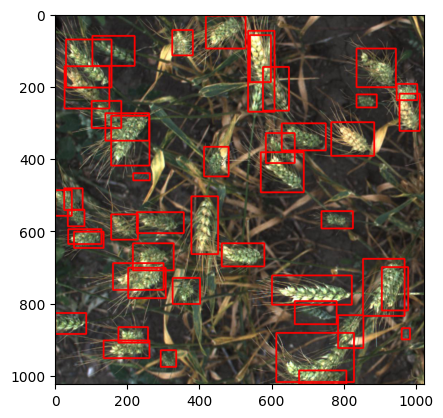

In [15]:
plt.imshow(image);

In [16]:
train_ds[0][1]['boxes'].shape

torch.Size([47, 4])

In [17]:
train_ds[1][1]['boxes'].shape

torch.Size([46, 4])

In [18]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
    
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  if isinstance(data,dict):
    return {key:to_device(value,device) for key,value in data.items()}
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device
      
  def __iter__(self):
      """Yield a batch of data after moving it to device"""
      for b in self.dl: 
          yield to_device(b, self.device)

  def __len__(self):
      """Number of batches"""
      return len(self.dl)
    

device=get_default_device()
device

device(type='cuda')

In [19]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [20]:
train_dl=DataLoader(train_ds,batch_size=8,shuffle=False,num_workers=0,collate_fn=collate_fn)

In [21]:
train_dl=DeviceDataLoader(train_dl,device)

In [22]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [23]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 245MB/s]


In [24]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [25]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

`AnchorGenerator`: This is an instance of the AnchorGenerator class. Anchors are predefined bounding boxes of different sizes and aspect ratios that are densely placed across the feature maps. The AnchorGenerator is responsible for generating anchors at each spatial location on the feature maps.

`RPNHead`: This is the head component of the RPN, responsible for processing the features and making predictions. It consists of the following layers:

`conv`: This is a Conv2dNormActivation layer sequence, which performs convolutional operations followed by activation. It takes the input features (in this case, with 256 channels) and applies a 3x3 convolution with 256 output channels and a padding of 1. The ReLU activation function is then applied to introduce non-linearity.

`cls_logits`: This is a Conv2d layer that performs a 1x1 convolution with the purpose of predicting the objectness score (classification) for each anchor. It takes the features from the previous layer (256 channels) and produces 3 output channels. These 3 channels correspond to the objectness scores of background, foreground, and ambiguous regions (typically represented as 0, 1, and -1).

`bbox_pred`: This is another Conv2d layer that performs a 1x1 convolution to predict the bounding box offsets for each anchor. It takes the features from the previous layer (256 channels) and outputs 12 channels. The 12 channels correspond to the 4 coordinates (x, y, width, height) of the predicted bounding box offsets for both the foreground and ambiguous regions.

`MultiScaleRoIAlign`: This is a module used for region of interest (RoI) pooling. It takes multiple feature maps (featmap_names) as input and aligns the regions of interest to a fixed spatial size (output_size). It performs pooling with bilinear interpolation and can handle feature maps from different scales. The sampling_ratio parameter specifies the number of points to sample within each bin during pooling.

`TwoMLPHead`: This is the box head component of the RoIHeads module. It is responsible for extracting features from the RoI-pooled regions. It consists of two fully connected layers (fc6 and fc7). The fc6 layer takes the RoI-pooled features as input and produces intermediate features with 1,024 output channels. The fc7 layer further processes the intermediate features and also outputs features with 1,024 channels.

`FastRCNNPredictor`: This is the box predictor component of the RoIHeads module. It takes the features extracted by the box head and predicts the class labels and bounding box offsets for each region of interest. It consists of two linear layers (cls_score and bbox_pred). The cls_score layer takes the features as input and outputs scores for two classes (in this case, 2 output features), indicating the probability of each RoI belonging to each class. The bbox_pred layer also takes the features as input and predicts the bounding box offsets (e.g., coordinates of the top-left and bottom-right corners) for each RoI.

In [26]:
model=model.to(device)
for batch in train_dl:
  images=batch[0]
  targets=batch[1]
  loss_dict = model(images, targets)
  break

In [27]:
loss_dict

{'loss_classifier': tensor(0.5804, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.8097, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(4.1510, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1686, device='cuda:0', grad_fn=<DivBackward0>)}

In [28]:
epochs=5
lr=0.005
optimizer=torch.optim.SGD(model.parameters(),lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [29]:
def fit_one_cycle(epochs, lr_scheduler, model, train_loader, optimizer, last_chk_pt=None):
  torch.cuda.empty_cache()
  history = []
  tr_loss_arr = []
  prev_epoch = 0
  checkpoint = None  # Initialize checkpoint variable

  if last_chk_pt != None:
    checkpoint = torch.load(last_chk_pt)
    prev_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = to_device(v, device)
          tr_loss_arr = checkpoint['Training Loss']
    to_device(model, device)

  for epoch in range(epochs):
    # Training Phase 
    model.train()

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:  
      images = batch[0]
      labels = batch[1]
      out_dict = model(images, labels)
      losses = sum(loss for loss in out_dict.values())

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      tr_loss_arr.append(losses.item())

      pbar.set_postfix({'Epoch': epoch+1+prev_epoch, 
                        'Training Loss': np.mean(tr_loss_arr)
                        })
    torch.save(checkpoint, f"model_{epoch+1+prev_epoch}.pth")
    lr_scheduler.step()
  return tr_loss_arr


In [30]:
history=[fit_one_cycle(epochs,lr_scheduler,model,train_dl,optimizer)]

100%|██████████| 422/422 [12:35<00:00,  1.79s/it, Epoch=5, Training Loss=0.854]


In [32]:
img=train_ds[0][0]
img=img.to(device)
model.eval()
outputs=model(img.unsqueeze(0))

In [ ]:
outputs

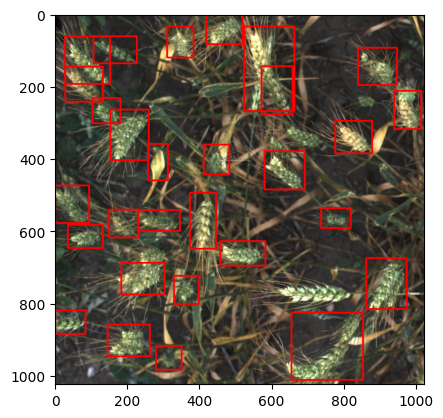

In [48]:
img,target=train_ds[0]
image=img.permute(1,2,0).cpu().numpy().copy()
boxes=outputs[0]['boxes'].detach().cpu().numpy().astype(np.int32)
indices=cv2.dnn.NMSBoxes(boxes,outputs[0]['scores'].detach().cpu().numpy().astype(np.float32),score_threshold=0.3, nms_threshold=0.4)
for c in indices:
  x1,y1,x2,y2=boxes[c]
  cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(image)